# Data Investigation and Preparation

In this notebook, we'll take a look at the obtained
data and its sources, discuss what needs to be done to
the data to better process it, justify cleaning
methods, and finally export a simplified, manageable
version of the data that was brought in.

After this step, we'll move on to the next notebook
[here](./step2.ipynb),
where we'll perform a little more data reduction as
needed and begin the modeling process.

## Overview

To begin, this project will be ongoing as new data
becomes available. The initial training data was
obtained on April 25th, 2023 from multiple sources.
This project aims to create pricing predictions for
Magic: the Gathering cards based on their abilities
or "Oracle Text" as provided. The primary benefit of
this project aims to be to inform players looking to
make informed purchasing decisions, game store owners
deciding on sales patterns, and various other
collectors et al that would be interested in the
buying, selling, and/or trading of Magic cards, with a
focus on cards coming from new sets with little to no
pricing data available.

The base understanding that this operates on is that
cards that do similar things with similar payoffs,
costs, and features can be expected to have similar
values.

Magic has a lot of different working parts, so trying
to understand and investigate what goes into the
pricing of the secondary market comes with a lot of
caveats that we'll be making an attempt at detecting.

An ability to reliably predict and work with pricing
can allow drastic improvement to informed purchasing
decisions.

## Data Sourcing and Authority

The main dataset for this project was obtained from
[ScryFall](https://scryfall.com/)
at
[their bulk data page](https://scryfall.com/docs/api/bulk-data),
specifically the All Cards JSON file.

Data for pricing (and the data to translate back to
Scryfall usability) was obtained from
[MtGJson](https://mtgjson.com/)
at
[their download page here](https://mtgjson.com/downloads/all-files/),
specifically the "AllPrintings" and "AllPrices" files.
This data is maintained and refreshed on a dail basis,
looking back at a 90-day period. At the sources
mentioned, there is not additional data available
retroactively.

[Scryfall](https://scryfall.com)
is one of the most robust search and sorting
databases available for Magic and is used by many
different applications. They have easily and freely
available data for most cases. This data set includes
the vast majority of features that will be utilized in
this project.

While Scryfall is very robust, the pricing data that it
provides isn't quite what we want to look at. It does
feature a price column, but it's only a snapshot of a
single day and wouldn't be insulated from price spikes.
While, in theory, this data could be collected daily
over the course of weeks or months, this also isn't
held historically. Because of this, we'll utilize
[MtGJson](https://mtgjson.com)
and the available "All Prices" data set that is
available there, as it contains prices from a 90-day
period, which should allow us to better insulate from
random spikes in prices.

In order to pair our data sets together, we need to get
the card IDs from the All Prices data set and get the
related Scryfall ID for each card. For this, we need
to use another data set from
[MtGJson](https://mtgjson.com)
that has all of the IDs that may be related to a card.

The prices available in both the Scryfall data and the
MtGJson data that we'll be looking at are prices from
[TCGPlayer](https://tcgplayer.com),
specifically the "Retail" or market prices. These
prices are made up of the mean prices of actual sales
that are made on the platform rather than the prices
that cards are listed at. Since TCGPlayer is the
largest online marketplace for Magic cards in the
United States, this data should be some of the most
accurate available.

The data from
[MtGJson](https://mtgjson.com)
also has prices from Card Kingdom, CardMarket, and some
others, but these prices are usually notoriously
higher, for foreign markets, or otherwise less
available for various reasons.

Additionally, the pricing data we're looking at will
only be for paper Magic, at least for the initial scope
of this project, though MtG:O pricing may be a target
at a later date.

As for my own authority on this data, I've been an avid
Magic player for almost a decade at this point. I've
been consistently buying and trading cards since early
2014 and have had several interpersonal relationships
with people that have made a business of the Magic
market in all categories of it.

Throughout this project, the features being used will
be adapted or changed over the project's course. As
these features are added or removed, justification will
be provided either before the relevant code block or
within it.

## Imports and Cleaning

Required packages for this project are available and
defined in the yaml file in the data/ folder for this
project. Non-standard functions are available in the
_code/ folder.

In [1]:
import gc
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from _code.card_selection import card_sampler, \
            plot_card_trends, card_imager, \
                synthesize_names

from IPython.display import Image

sns.set()

### Translator Creation

We'll start by bringing in the data from MtGJson that
will let us translate from those IDs to the Scryfall
IDs.

In [2]:
trans_df = pd.read_json('./data/AllPrintings.json')
trans_df.head()

,meta,data
date,2023-04-27,NaN
version,5.2.1+20230427,NaN
10E,NaN,"{'baseSetSize': 383, 'block': 'Core Set', 'boo..."
2ED,NaN,"{'baseSetSize': 302, 'block': 'Core Set', 'boo..."
2X2,NaN,"{'baseSetSize': 577, 'booster': {'collector': ..."


The MtGJson data has a meta section that sits outside
of the regular data. We can safely drop this column and
the two rows that are missing data.

Additionally, this data is from before the release of
the March of Machines set, and those cards, by
extension, have either missing or incomplete pricing
data. We'll go ahead and drop these sets now and show
the resulting data frame here.

In [3]:
trans_df.drop(columns='meta',inplace=True)

# the set March of the Machines was still in preview
# when this data was initially collected. We'll drop
# the entries from this set here.
trans_df.drop(['MOM','FMOM'],inplace=True)
# 'FMOM' is specific to the face cards for the
# jumpstart set
trans_df.dropna(inplace=True)
display(
    trans_df.head(),
    trans_df.info()
    )

<class 'pandas.core.frame.DataFrame'>
Index: 693 entries, 10E to ZNR
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    693 non-null    object
dtypes: object(1)
memory usage: 10.8+ KB


,data
10E,"{'baseSetSize': 383, 'block': 'Core Set', 'boo..."
2ED,"{'baseSetSize': 302, 'block': 'Core Set', 'boo..."
2X2,"{'baseSetSize': 577, 'booster': {'collector': ..."
2XM,"{'baseSetSize': 332, 'booster': {'default': {'..."
30A,"{'baseSetSize': 594, 'booster': {'default': {'..."


None

This data set looks at every set that has ever been
release throughout Magic's history. Since we want to
extract the information for each individual card, we
need to loop through the sets and create a new
dataframe made up of the MtGJson IDs and the Scryfall
IDs so that we can do the translation mentioned
earlier.

In [4]:
trans_df['data'].loc['10E']['cards'][0].keys()

dict_keys(['artist', 'availability', 'boosterTypes', 'borderColor', 'colorIdentity', 'colors', 'convertedManaCost', 'edhrecRank', 'edhrecSaltiness', 'finishes', 'foreignData', 'frameVersion', 'hasFoil', 'hasNonFoil', 'identifiers', 'isReprint', 'keywords', 'language', 'layout', 'legalities', 'manaCost', 'manaValue', 'name', 'number', 'originalText', 'originalType', 'power', 'printings', 'purchaseUrls', 'rarity', 'rulings', 'setCode', 'subtypes', 'supertypes', 'text', 'toughness', 'type', 'types', 'uuid', 'variations'])

In [5]:
id_mixer = []
for _set in trans_df['data'].index:
    for card in trans_df['data'].loc[_set]['cards']:
        id_mixer.append(
                        {
                            'scryfall': card['identifiers']['scryfallId'],
                            'uuid':     card['uuid'],
                            'name':     card['name'],
                            'set':      _set
                        })
id_mixer[:5]

[{'scryfall': '7a5cd03c-4227-4551-aa4b-7d119f0468b5',
  'uuid': '5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c',
  'name': "Ancestor's Chosen",
  'set': '10E'},
 {'scryfall': '82072a1d-c1ab-4b4f-875f-d0591447e0a4',
  'uuid': 'b7c19924-b4bf-56fc-aa73-f586e940bd42',
  'name': "Ancestor's Chosen",
  'set': '10E'},
 {'scryfall': '8f7980d4-da43-4d6d-ad16-14b8a34ae91d',
  'uuid': '57aaebc1-850c-503d-9f6e-bb8d00d8bf7c',
  'name': 'Angel of Mercy',
  'set': '10E'},
 {'scryfall': 'b0157252-6949-4f03-a15c-c168512123a8',
  'uuid': '8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a',
  'name': 'Angel of Mercy',
  'set': '10E'},
 {'scryfall': 'a285aa3f-bcfb-4fc3-8441-85a56c72a3e4',
  'uuid': '55bd38ca-dc73-5c06-8f80-a6ddd2f44382',
  'name': 'Angelic Blessing',
  'set': '10E'}]

In [6]:
# Convert id_mixer to a dataframe to merge the cards
# then delete the id_mixer frame to free up memory 
id_mixer_df = pd.DataFrame(id_mixer)
del id_mixer
gc.collect()

id_mixer_df.head()

,scryfall,uuid,name,set
0,7a5cd03c-4227-4551-aa4b-7d119f0468b5,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c,Ancestor's Chosen,10E
1,82072a1d-c1ab-4b4f-875f-d0591447e0a4,b7c19924-b4bf-56fc-aa73-f586e940bd42,Ancestor's Chosen,10E
2,8f7980d4-da43-4d6d-ad16-14b8a34ae91d,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c,Angel of Mercy,10E
3,b0157252-6949-4f03-a15c-c168512123a8,8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a,Angel of Mercy,10E
4,a285aa3f-bcfb-4fc3-8441-85a56c72a3e4,55bd38ca-dc73-5c06-8f80-a6ddd2f44382,Angelic Blessing,10E


The name and set columns here are kept to more easily
visualize what's happening throughout this process and
to double check that everything is squared away
correctly.

### Price Data Preparation

Now, we can import the pricing data to prepare it for
merging with the Scryfall data and check the sizes of
all of our dataframes before moving on.

In [7]:
all_prices = pd.read_json('./data/AllPrices.json')

len(all_prices),\
len(id_mixer_df['scryfall'].unique()), \
len(id_mixer_df['uuid'].unique())

(80095, 78639, 79947)

Since the dataframes are all different sizes, there may
be duplicates or mis-matched entries. We'll take a look
at the Scryfall ID values here to see if there are any
that exist multiple times in the data sets.

In [8]:
id_mixer_df['scryfall'].value_counts()

scryfall
fea4a077-718b-44af-87be-90df61aab643    5
8987644d-5a31-4a4e-9a8a-3d6260ed0fd6    5
097165ee-f959-49e3-a5c1-f78043e538d9    3
25d09421-08d5-4ca9-8937-5f937bc9c929    3
d20738d2-a159-4e3e-be7a-561a121bd447    2
                                       ..
6fa863a1-8d36-424d-bb65-8e0424617769    1
12604a80-d803-4598-b2b6-345c47fe9af6    1
4680a8da-69bd-4dc9-b7b0-e15d9488a8d5    1
bcdc3fb1-667e-49d7-b677-b70e6e217f4f    1
cbef1409-4e7c-445e-ae6b-b3133faf1f73    1
Name: count, Length: 78639, dtype: int64

It seems like several of the Scryfall IDs exist
multiple times in our translation set. We'll go ahead
and make a smaller dataframe to extract the counts and
see what exactly is going on in here.

In [9]:
counts = pd.DataFrame(
    id_mixer_df['scryfall'].value_counts().rename('counts')
    )

counted_mixer = id_mixer_df.merge(
    counts,
    left_on='scryfall',
    right_index=True,
    how='left'
)
del counts
gc.collect()

duplicates = counted_mixer[counted_mixer['counts'] > 1]
duplicates.head()

,scryfall,uuid,name,set,counts
7665,d6fc6ed9-740a-4726-8f2c-5d662636f687,a7c38e21-6688-54a6-ae77-ced41669abe9,Realm-Cloaked Giant // Cast Off,AFC,2
7666,d6fc6ed9-740a-4726-8f2c-5d662636f687,131f4174-02e8-5435-ad81-e90fc1b849cb,Realm-Cloaked Giant // Cast Off,AFC,2
8579,937dbc51-b589-4237-9fce-ea5c757f7c48,f9f10d34-071c-57a6-b58c-7553abad5c20,Dusk // Dawn,AKH,2
8580,937dbc51-b589-4237-9fce-ea5c757f7c48,87f0062a-8321-5c16-960e-a12ce1df5839,Dusk // Dawn,AKH,2
8581,06c9e2e8-2b4c-4087-9141-6aa25a506626,71a0621f-32a6-5450-8ad8-6cdae505cf59,Commit // Memory,AKH,2


We should go ahead and make sure that that merge didn't
create any null values before moving on to the next
step.

In [10]:
counted_mixer['counts'].isna().sum()

0

One more sanity check, we'll make sure that the
duplicates we see here are lining up with the
duplicates in the original data frame.

In [11]:
counted_mixer['scryfall'].shape[0]-counted_mixer['scryfall'].nunique(),\
    len(duplicates) - duplicates['scryfall'].nunique()

(1308, 1308)

One nice thing that the Scryfall data set has that our
other ones don't have is a uri for different card
images. We'll go ahead and import the Scryfall data now
so that we can directly look at the cards that we're
finding issues with.

Additionally, we'll reduce the size of this data frame
to only the items we intend to look at so that our
processes all run a little bit more smoothly.

In [12]:
all_cards = pd.read_json('./data/ScryfallData.json')

used_columns = [
    # 'object',         # this is a raw numeric ID for
                        # identifying each card that we
                        # won't be using, our other id
                        # methods will be much better
                        # suited. 
    'id',
    'oracle_id',
    # 'multiverse_ids', # these ids are not going to be
    # 'mtgo_id',        # useful for us in any way
    # 'mtgo_foil_id',   #
    # 'tcgplayer_id',   #
    # 'cardmarket_id',  #
    'name',
    'lang',             # <= reduce this to english, not
                        # going to be representative at
                        # scale but will reduce the data
                        # for legibility 

    'released_at',      # the age of a card may be
                        # useful for analysis later
    # 'uri',
    # 'scryfall_uri',
    'layout',           # <= determines frame, need to drop:
                        # token, emblem, scheme, vanguard 
    # 'highres_image',  # this is a true or false value
                        # that just determines if Scryfall
                        # has a hi-res image 
    # 'image_status',
    'image_uris',       # <= This will allow us to display
                        # images throughout the process
                        # as needed 

    'mana_cost',        # the cost of a card can be very
                        # important to its price.
    'cmc',              # this is the total mana value
                        # it takes to use a card
    'type_line',        # different card types have
                        # different ways to use them
    'oracle_text',      # <= going to use NLP on this
                        # to get what the card does in
                        # a programmatic way 

    'power',            # each of these have a strong
    'toughness',        # bearing on how well a card
    'colors',           # is used or performs
    'color_identity',
    'keywords',
    'legalities',       # <= need to convert this into
                        # dummied columns 

    'games',            # <= limit to 'paper' then drop

    'reserved',         # <= need to determine if this
                        # is going to be used as an
                        # influence or not, meta-
                        # knowledge says that it is 

    'foil',
    'nonfoil',
    # 'finishes',         # <= this is likely determined
                        # by the foil and nonfoil column

    'oversized',        # <= need to drop where True, 
                        # then drop the column itself 
    'promo',
    'reprint',
    'variation',
    'set_id',
    'set',
    # 'set_name',         # <= have other ways to match
                        # set data

    'set_type',
    # 'set_uri',
    # 'set_search_uri',
    # 'scryfall_set_uri',
    # 'rulings_uri',
    # 'prints_search_uri',
    # 'collector_number',
    # 'digital',
    'rarity',
    # 'flavor_text',
    # 'card_back_id',
    # 'artist',
    # 'artist_ids',
    # 'illustration_id',
    'border_color',     # <= remove silver and gold-
                        # border cards then drop
    # 'frame',
    'full_art',
    'textless',
    # 'booster',
    # 'story_spotlight',
    'edhrec_rank',
    # 'penny_rank',
    # 'prices',           # <= we'll use the prices from
                        # the other data set instead of
                        # this one 
    'related_uris',
    # 'printed_name',
    # 'printed_type_line',
    # 'printed_text',
    # 'security_stamp',
    # 'all_parts',
    'promo_types',
    # 'arena_id',
    'loyalty',
    # 'watermark',
    # 'frame_effects',
    # 'preview',
    'produced_mana',            # <= may not make it into
                                # the final model since
                                # the text should also
                                # have this

    # 'card_faces',               # <= probably don't need
                                # this since cards are
                                # always listed as both
                                # faces 
    # 'color_indicator',          # <= an extra part of
                                # color identity
    # 'tcgplayer_etched_id',      # <= id for etched card
                                # on tcgplayer

    # 'content_warning',          # <= 'illegal' cards
    # 'attraction_lights',        # <= is part of unset
                                # mechanics
    'variation_of',
    # 'life_modifier',          # part of vanguard
    # 'hand_modifier',          # """"""
    # 'flavor_name'             # <= redundant of name
                                # on cards that are
                                # nickname cards 
]

all_cards = all_cards[used_columns].copy()

In [13]:
display(all_cards.head(), all_cards.shape)

,id,oracle_id,name,lang,released_at,layout,image_uris,mana_cost,cmc,type_line,...,rarity,border_color,full_art,textless,edhrec_rank,related_uris,promo_types,loyalty,produced_mana,variation_of
0,0000579f-7b35-4ed3-b44c-db2a538066fe,44623693-51d6-49ad-8cd7-140505caf02f,Fury Sliver,en,2006-10-06,normal,{'small': 'https://cards.scryfall.io/small/fro...,{5}{R},6.0,Creature — Sliver,...,uncommon,black,False,False,6038.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
1,00006596-1166-4a79-8443-ca9f82e6db4e,8ae3562f-28b7-4462-96ed-be0cf7052ccc,Kor Outfitter,en,2009-10-02,normal,{'small': 'https://cards.scryfall.io/small/fro...,{W}{W},2.0,Creature — Kor Soldier,...,common,black,False,False,15041.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
2,00009878-d086-46f0-a964-15734d8368ac,30cd69a8-7893-4075-94ca-04450ff821d3,Spirit of the Hearth,fr,2017-08-25,normal,{'small': 'https://cards.scryfall.io/small/fro...,{4}{W}{W},6.0,Creature — Cat Spirit,...,rare,black,False,False,9831.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
3,0000a54c-a511-4925-92dc-01b937f9afad,dc4e2134-f0c2-49aa-9ea3-ebf83af1445c,Spirit,en,2015-05-22,token,{'small': 'https://cards.scryfall.io/small/fro...,,0.0,Token Creature — Spirit,...,common,black,False,False,NaN,{'tcgplayer_infinite_articles': 'https://infin...,[setpromo],NaN,NaN,NaN
4,0000cd57-91fe-411f-b798-646e965eec37,9f0d82ae-38bf-45d8-8cda-982b6ead1d72,Siren Lookout,en,2017-09-29,normal,{'small': 'https://cards.scryfall.io/small/fro...,{2}{U},3.0,Creature — Siren Pirate,...,common,black,False,False,13249.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN


(415580, 38)

Now that we have our Scryfall data imported, we can
take a peek at the first duplicate in our list and try
to figure out why this might be happening.

348891    Realm-Cloaked Giant // Cast Off
Name: name, dtype: object


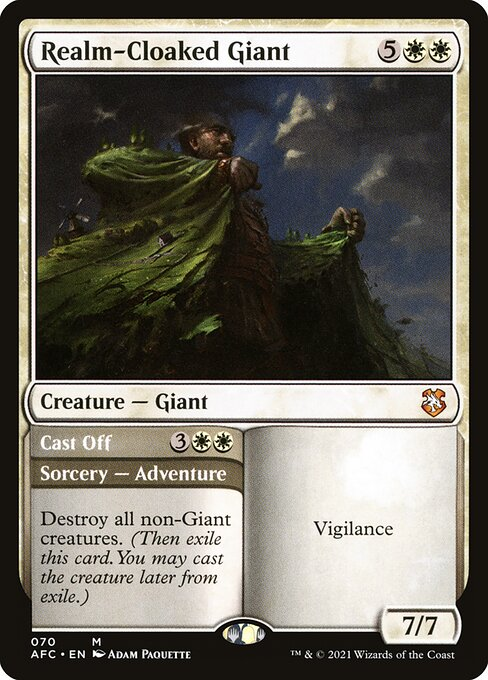

In [15]:
duplicate_card = all_cards[
    all_cards['id'] == duplicates['scryfall'].iloc[0]
    ]

print(duplicate_card['name'])

# image uris have extra information at the end that is
# denoted by a ?, this needs to be stripped to be
# displayed properly 
Image(duplicate_card['image_uris'].iloc[0]['normal'].split('?')[0])

This card having a duplicate entry makes sense, since
the card itself is effectively 2 separate cards on its
own. It has the option to be cast as either
"Realm-Cloaked Giant" or as "Cast Off". These kinds of
cards are often represented with a "//" in their names
to show that there is another name on the card. Since
they effectively have two completely different
abilities, they have to have 2 different rules entries.

This makes sense for the entries with two values, but
what is going on with the one that has _**FIVE**_?

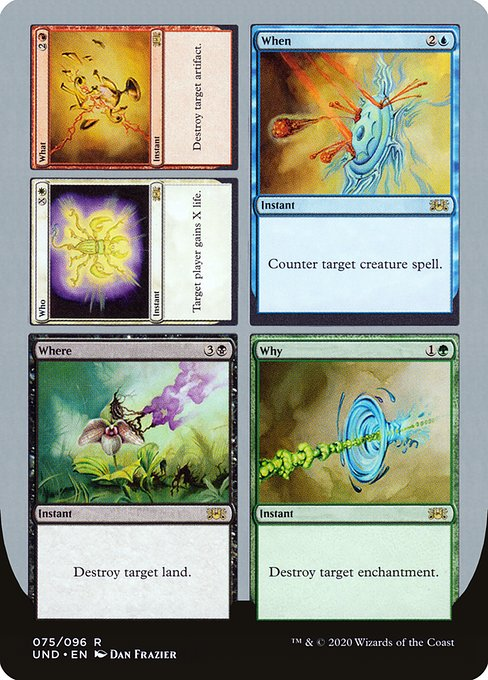

In [16]:
Image(all_cards[all_cards['id'] ==
    duplicates.sort_values('counts',ascending=False)['scryfall'].iloc[0]
    ]['image_uris'].iloc[0]['normal'].split('?')[0])

This card has a silver border, meaning it is from
what's known as an "un-" set. These are cards that are
printed as more of a joke and aren't really playable in
any kind of sanctioned format. These cards can have
extremely high power but since they aren't able to be
played in anything, they rarely hold value - no matter
what they do. We can safely remove these cards from our
data set as they really aren't representative of
anything.

Before we do that, we'll go ahead and drop "meta" from
the prices data set just like we did with the "All
Cards" data before.

In [17]:
all_prices = all_prices.drop(columns="meta").dropna()
all_prices.head()

For our process of narrowing down our card data, we
want to look at cards that are, generally speaking,
"actual cards." These are cards that are observed in
our market data set and are played with some sort of
reliability.

This means we'll want to look only at cards that are in
English, cards that are normal-sized, cards that are of
a legal card type to play as part of a deck, physical
cards, cards that have been originally printed as part
of a set that was intended to see long-term play, cards
with a card type, and cards that were not part of a
special set that was specifically designed as a
non-playable item.

Several of these categories overlap, but usually have a
very specific distinction that is a little bit outside
of the scope of this project to explain.

Between each reduction in the data frame, we'll print
out the size of it so that we can see just how much our
data is being cut down.

In [18]:
print(all_cards.shape)
# only looking at english cards
all_cards = all_cards[all_cards['lang'] == 'en']
print(all_cards.shape)
# only want playable cards
all_cards = all_cards[all_cards['oversized'] == False]
print(all_cards.shape)
# determines frame, need to drop: token, emblem, scheme, vanguard
all_cards = all_cards[
    (~all_cards['layout'].isin(['token','emblem','scheme','vanguard']))
    ]
print(all_cards.shape)
# reduce this to only cards thate are printed on paper
all_cards = all_cards[all_cards['games'].map(
                lambda x: 'paper' in x
            )]
print(all_cards.shape)
# strip out gold and silver border cards from the set
all_cards = all_cards[(all_cards['border_color'] != 'silver') &
                    (all_cards['border_color'] != 'gold')]
print(all_cards.shape)
# every card has a type line, if that's missing - the
# entry is broken. 
all_cards = all_cards[~all_cards['type_line'].isna()]
print(all_cards.shape)
# remove all cards that are from mystery booster
# playtest sets 
all_cards = all_cards[~all_cards['set'].isin(['cmb1','cmb2'])]
print(all_cards.shape)

###########################

cleaned_cards = all_cards.drop(columns=[
    'lang','oversized','layout','games','border_color'
])

print(cleaned_cards.shape)
del all_cards
gc.collect();

(415580, 38)
(80033, 38)
(79470, 38)
(77435, 38)
(69414, 38)
(67533, 38)
(67520, 38)
(67280, 38)
(67280, 33)


0

Our full data set started out with 415,580 entries -
which includes a unique entry for every single
different language a card could be printed in. Going
from all languages down to just English alone brought
us down to 80,033 entries. The rest of our processes
seemed to only bring our counts down incrementally,
leaving us with 67,280 cards for our final set.

Now that we have our Scryfall data reduced
substantially down to something that's relatively
manageable by comparison, let's take a closer look at
the duplicate cards from before. We can make sure that
all of the cards with multiple entries are cases that
we were seeing before.

In [19]:
# here, we reduce the duplicates data frame down to
# one of each card according to our scryfall data
reduced_dupes = duplicates.merge(
    cleaned_cards['id'],
    left_on='scryfall',
    right_on='id',
    how='inner'
)

# we don't need multiple id columns
reduced_dupes.drop(columns='id',inplace=True)

# collecting a list of each unique scryfall id
scryfall_ids = reduced_dupes['scryfall'].unique()

# define arrays to store our failed cards or cards that
# have unequal prices in their data
unequal_cards = []
failed_cards  = []

for _sf_id in scryfall_ids:
    # steps are defined and labelled so that we can
    # create a combined dataframe that shows where each
    # card was having issues processing.
    # If the process fails at any point, it will be
    # saved off as part of an exception 
    step='initializing scryfall id'
    _card_entry = reduced_dupes[reduced_dupes['scryfall'] == _sf_id]
    _check_ids = list(_card_entry['uuid'].values)
    try:
        _prices = {}
        _price_type = []

        step = f'pricing'
        for _id in _check_ids:
            _price_list = all_prices[
                all_prices.index == _id
            ]['data'].iloc[0]['paper']['tcgplayer']['retail']

            step=f"get price ... id: {_id}"
            _type = sorted(list(_price_list.keys()))[0]
            _price_type.append(_type)
            _prices[_id] = _price_list[_type]
        
        step = 'loading test'
        _price_test = [price for price in list(_prices.values())]

        step = 'check equal'
        # ensure that all prices in the array of each
        # card are the same 
        is_equal = (sum(
            np.array(
                list(_price_test[0].values())
                ) - np.array(
                    list(_price_test[1].values()))
            )==0)
        if ~is_equal:

            step='unequal'
            for i, k in enumerate(_card_entry.index):
                unequal_cards.append(
                    {
                        'name':_card_entry.loc[k]['name'],
                        'uuid':_card_entry.loc[k]['uuid'],
                        'scryfall':_card_entry.loc[k]['scryfall'],
                        'prices':list(
                                _price_test[i].values()
                                ),
                        'price_type':_price_type[i]
                    }
                    )
    except:
        # if the above process fails at any point,
        # generate a dataframe entry that describes
        # what card failed, what the values were, and
        # what the step was that it failed on. 
        for i, k in enumerate(_card_entry.index):
                failed_cards.append(
                {
                    'name':_card_entry.loc[k]['name'],
                    'uuid':_card_entry.loc[k]['uuid'],
                    'scryfall':_card_entry.loc[k]['scryfall'],
                    'prices':list(
                            _price_test[i].values()
                            ),
                    'price_types':_price_type,
                    'failed_step':step
                }
        )

# remove the temporary variables generated in this
# process 
del reduced_dupes
del duplicates
del scryfall_ids
gc.collect()


# this was being used for testing and finding issues in
# the separation of values from the previous cell. 
# These issues have been corrected.
# This block of code is being preserved to show the
# methodology in ensuring the data is correct. 
# unequal_cards = pd.DataFrame(unequal_cards)
# unequal_cards[['name','prices']].iloc[:2]['prices']
# unequal_cards[['name','prices','price_type']] 
unequal_cards

[]

In [20]:
failed_cards = pd.DataFrame(failed_cards)
failed_cards[['name','prices','price_types','failed_step']]

,name,prices,price_types,failed_step
0,Struggle // Survive,"[0.19, 0.19, 0.19, 0.15, 0.15, 0.14, 0.14, 0.1...",[],pricing
1,Struggle // Survive,"[0.19, 0.19, 0.19, 0.15, 0.15, 0.14, 0.14, 0.1...",[],pricing
2,Collectigull // Only the Best,"[1.58, 1.55, 1.58, 1.55, 1.55, 1.55, 1.51, 1.5...",[],pricing
3,Collectigull // Only the Best,"[1.58, 1.55, 1.58, 1.55, 1.55, 1.55, 1.51, 1.5...",[],pricing
4,Champions of Archery // Join the Group,"[1.58, 1.55, 1.58, 1.55, 1.55, 1.55, 1.51, 1.5...",[],pricing
5,Champions of Archery // Join the Group,"[1.58, 1.55, 1.58, 1.55, 1.55, 1.55, 1.51, 1.5...",[],pricing
6,Nezumi Graverobber // Nighteyes the Desecrator,"[1.06, 1.04, 1.04, 1.04, 1.04, 1.04, 1.04, 1.0...",[],pricing
7,Nezumi Graverobber // Nighteyes the Desecrator,"[1.06, 1.04, 1.04, 1.04, 1.04, 1.04, 1.04, 1.0...",[],pricing
8,Nezumi Graverobber // Nighteyes the Desecrator,"[1.06, 1.04, 1.04, 1.04, 1.04, 1.04, 1.04, 1.0...",[],pricing
9,Nezumi Graverobber // Nighteyes the Desecrator,"[1.06, 1.04, 1.04, 1.04, 1.04, 1.04, 1.04, 1.0...",[],pricing


Here, we'll generate some more testing items to look
into what's going on under the hood with some of the
cards that are failing the processes.

In [21]:
# we create a failed_prices here to show what the
# prices are for the cards that failed so we can take
# a look at what might have happened 
failed_prices = all_prices.merge(
    failed_cards,
    left_index=True,
    right_on='uuid',
    how='right'
)

# this loop tries to navigate into each card's pricing
# data to look at what data is missing for each card.
# When it finds missing data, it reports the failure
# just like before but is a little more granular. The
# process is trying to find specific places where data
# is missing rather than just a general idea that the
# entry is missing something. 

checked_values = []
for i in range(0,len(failed_prices)):
    name = ''
    try:
        _foil = None
        _normal = None

        step='entering'
        failed_prices.iloc[i]

        step='locating'
        failed_prices.iloc[i]['name']
        
        step='name'
        name=failed_prices.iloc[i]['name']
        failed_prices.iloc[i]['data']
        
        step='data'
        failed_prices.iloc[i]['data']['paper']
        
        step='paper'
        failed_prices.iloc[i]['data']['paper']['tcgplayer']
        
        step='tcgplayer'
        failed_prices.iloc[i]['data']['paper']['tcgplayer']['retail']
        
        step='retail'
        try:
            failed_prices.iloc[i]['data']['paper']['tcgplayer']['retail']['normal']
        
            step='normal'
            _normal = True
        except:
            _normal = False
        try:
            failed_prices.iloc[i]['data']['paper']['tcgplayer']['retail']['foil']
        
            step='foil'
            _foil = True
        except:
            _foil = False
        
        step='complete'
    except:
        None
    checked_values.append({
        'step':step,
        'name': name,
        'foil':_foil,
        'normal':_normal
    })

display(pd.DataFrame(checked_values))

del checked_values
gc.collect();

,step,name,foil,normal
0,tcgplayer,Struggle // Survive,None,None
1,tcgplayer,Struggle // Survive,None,None
2,tcgplayer,Collectigull // Only the Best,None,None
3,tcgplayer,Collectigull // Only the Best,None,None
4,tcgplayer,Champions of Archery // Join the Group,None,None
5,tcgplayer,Champions of Archery // Join the Group,None,None
6,data,Nezumi Graverobber // Nighteyes the Desecrator,None,None
7,data,Nezumi Graverobber // Nighteyes the Desecrator,None,None
8,data,Nezumi Graverobber // Nighteyes the Desecrator,None,None
9,data,Nezumi Graverobber // Nighteyes the Desecrator,None,None


The majority of the cards listed have no data
specifically from TCGPlayer. It looks like there is one
card that is listed multiple times that just doesn't
have any data at all. Since this is only 5 individual
cards, we can safely remove these from the data set, as
they like just don't have any sales data available.

Let's take one more look at our data sets before we try
to put everything together with our translation step.

In [22]:
print("all_prices")
display(all_prices.head(),
all_prices.shape)

print("id_mixer")
display(id_mixer_df.head(),
id_mixer_df.shape)

print("Nulls in id_mixer and all_prices respectively")
id_mixer_df.isna().sum().sum() , all_prices.isna().sum().sum()

all_prices


,data
00010d56-fe38-5e35-8aed-518019aa36a5,{'paper': {'cardkingdom': {'buylist': {'foil':...
0001e0d0-2dcd-5640-aadc-a84765cf5fc9,{'paper': {'cardkingdom': {'buylist': {'normal...
0003caab-9ff5-5d1a-bc06-976dd0457f19,{'mtgo': {'cardhoarder': {'retail': {'foil': {...
0003d249-25d9-5223-af1e-1130f09622a7,{'mtgo': {'cardhoarder': {'retail': {'foil': {...
0004a4fb-92c6-59b2-bdbe-ceb584a9e401,{'mtgo': {'cardhoarder': {'retail': {'normal':...


(80093, 1)

id_mixer


,scryfall,uuid,name,set
0,7a5cd03c-4227-4551-aa4b-7d119f0468b5,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c,Ancestor's Chosen,10E
1,82072a1d-c1ab-4b4f-875f-d0591447e0a4,b7c19924-b4bf-56fc-aa73-f586e940bd42,Ancestor's Chosen,10E
2,8f7980d4-da43-4d6d-ad16-14b8a34ae91d,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c,Angel of Mercy,10E
3,b0157252-6949-4f03-a15c-c168512123a8,8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a,Angel of Mercy,10E
4,a285aa3f-bcfb-4fc3-8441-85a56c72a3e4,55bd38ca-dc73-5c06-8f80-a6ddd2f44382,Angelic Blessing,10E


(79947, 4)

Nulls in id_mixer and all_prices respectively


(0, 0)

With no nulls in our data, we can perform our
translation step.

### Merging Pricing Data

One of the last parts of our data compiling is merging
all of our data frames together. We need to end up with
a frame that has every card and its pricing data all in
the same place so that we can move on to our actual
analysis and visualizations.

In [23]:
translated_prices = id_mixer_df.merge(
    all_prices,
    left_on='uuid',
    right_index=True,
    how='left'
)
display(translated_prices.head(),translated_prices.shape)

,scryfall,uuid,name,set,data
0,7a5cd03c-4227-4551-aa4b-7d119f0468b5,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c,Ancestor's Chosen,10E,{'paper': {'cardkingdom': {'buylist': {'normal...
1,82072a1d-c1ab-4b4f-875f-d0591447e0a4,b7c19924-b4bf-56fc-aa73-f586e940bd42,Ancestor's Chosen,10E,{'paper': {'cardkingdom': {'buylist': {'foil':...
2,8f7980d4-da43-4d6d-ad16-14b8a34ae91d,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c,Angel of Mercy,10E,{'paper': {'cardkingdom': {'buylist': {'normal...
3,b0157252-6949-4f03-a15c-c168512123a8,8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a,Angel of Mercy,10E,{'paper': {'cardkingdom': {'buylist': {'foil':...
4,a285aa3f-bcfb-4fc3-8441-85a56c72a3e4,55bd38ca-dc73-5c06-8f80-a6ddd2f44382,Angelic Blessing,10E,{'paper': {'cardkingdom': {'buylist': {'normal...


(79947, 5)

Since we merged from our cleaned data to our untouched
data, we'll go ahead and remove any nulls and
duplicates that were produced.

In [24]:
print(translated_prices.shape)
translated_prices.dropna(inplace=True)
translated_prices.drop_duplicates('scryfall',inplace=True)
translated_prices.shape

(79947, 5)


(74329, 5)

In [25]:
translated_prices.head()

,scryfall,uuid,name,set,data
0,7a5cd03c-4227-4551-aa4b-7d119f0468b5,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c,Ancestor's Chosen,10E,{'paper': {'cardkingdom': {'buylist': {'normal...
1,82072a1d-c1ab-4b4f-875f-d0591447e0a4,b7c19924-b4bf-56fc-aa73-f586e940bd42,Ancestor's Chosen,10E,{'paper': {'cardkingdom': {'buylist': {'foil':...
2,8f7980d4-da43-4d6d-ad16-14b8a34ae91d,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c,Angel of Mercy,10E,{'paper': {'cardkingdom': {'buylist': {'normal...
3,b0157252-6949-4f03-a15c-c168512123a8,8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a,Angel of Mercy,10E,{'paper': {'cardkingdom': {'buylist': {'foil':...
4,a285aa3f-bcfb-4fc3-8441-85a56c72a3e4,55bd38ca-dc73-5c06-8f80-a6ddd2f44382,Angelic Blessing,10E,{'paper': {'cardkingdom': {'buylist': {'normal...


Let's take a look at what data is available from the
"Printings" option inside our retail data. Since there
are several different types of printings for cards, we
need to make sure that there aren't any that we're
missing in terms of the data we have - we need to make
sure we know if the data set is treating something like
a "textured" foil differently from a regular foil.

In [26]:
_listed_printings = []
for _card in translated_prices['data']:
    try:
        _listed_printings.extend(list(_card['paper']['tcgplayer']['retail'].keys()))
    except:
        continue
set(_listed_printings), len(_listed_printings)

({'foil', 'normal'}, 101626)

It looks like our data set treats cards as either
"foil" or "normal" so we can break our data out so that
it isn't stored in a stacked sort of way, that way we
can actually utilize it in our upcoming steps.

In [27]:
flattened_prices = []
for i, _card in translated_prices.iterrows():
    _flat = {
        'prices_normal':None,
        'prices_foil':None
    }
    _flat['scryfall'] = _card['scryfall']
    # we'll try creating our normal and foil prices
    # here, as long as they exist that is. If they
    # don't, we need to put Nones in their place 
    try:
        _flat['prices_normal'] = _card['data']['paper']['tcgplayer']['retail']['normal']
    except:
        None
    try:
        _flat['prices_foil'] = _card['data']['paper']['tcgplayer']['retail']['foil']
    except:
        None
    flattened_prices.append(_flat)

flattened_prices = pd.DataFrame(flattened_prices)
flattened_prices.head()

,prices_normal,prices_foil,scryfall
0,"{'2023-01-27': 0.1, '2023-01-28': 0.1, '2023-0...","{'2023-01-27': 0.64, '2023-01-28': 0.64, '2023...",7a5cd03c-4227-4551-aa4b-7d119f0468b5
1,"{'2023-01-27': 0.1, '2023-01-28': 0.1, '2023-0...","{'2023-01-27': 0.64, '2023-01-28': 0.64, '2023...",82072a1d-c1ab-4b4f-875f-d0591447e0a4
2,"{'2023-01-27': 0.07, '2023-01-28': 0.07, '2023...","{'2023-01-27': 1.16, '2023-01-28': 1.16, '2023...",8f7980d4-da43-4d6d-ad16-14b8a34ae91d
3,"{'2023-01-27': 0.07, '2023-01-28': 0.07, '2023...","{'2023-01-27': 1.16, '2023-01-28': 1.16, '2023...",b0157252-6949-4f03-a15c-c168512123a8
4,"{'2023-01-27': 0.1, '2023-01-28': 0.1, '2023-0...","{'2023-01-27': 0.21, '2023-01-28': 0.21, '2023...",a285aa3f-bcfb-4fc3-8441-85a56c72a3e4


Now, we can put our prices with our Scryfall data
directly and we'll be done with our MtGJson sets.

In [28]:
cards_attached_prices = cleaned_cards.merge(
    flattened_prices,
    left_on='id',
    right_on='scryfall'
).drop(columns='scryfall')

print(f"""    Shapes:
cleaned_cards:          {cleaned_cards.shape}
flattened_prices:       {flattened_prices.shape}
cards_attached_prices:  {cards_attached_prices.shape}
""")

    Shapes:
cleaned_cards:          (67280, 33)
flattened_prices:       (74329, 3)
cards_attached_prices:  (65169, 35)



We lost a chunk of data from our merge, but we already
know that the cleaned_cards frame was going to be
reduced some after removing cards that were missing
pricing data.

We'll go ahead and remove some of our unused variables
to move on to the last steps in our initial processing.

In [29]:
del flattened_prices, cleaned_cards, failed_cards,\
    failed_prices, id_mixer_df, \
    counted_mixer, trans_df, translated_prices, \
    used_columns, unequal_cards, duplicate_card, \
    all_prices
gc.collect();

0

## Finalizing Our Data

Before we're out of the processing step, we need to get
everything we'll need lined up. We'll visualize some of
the parts of our data before we save everything off to
begin creating our model.

We'll start off by looking at how the data is stored
for prices again and then look for an instances where
we're missing prices still.

In [30]:
cards_attached_prices.iloc[0]['name'], \
    dict(list(cards_attached_prices.iloc[0]['prices_normal'].items())[:5])

('Fury Sliver',
 {'2023-01-27': 0.37,
  '2023-01-28': 0.37,
  '2023-01-29': 0.37,
  '2023-01-31': 0.37,
  '2023-02-01': 0.37})

In [31]:
cards_attached_prices[
    (cards_attached_prices['prices_normal'].isna()) &
    (cards_attached_prices['prices_foil'].isna())
    ]['name']

35                     Mox Jet
149             Cyclopean Tomb
195               Disintegrate
265                      Taiga
401                  Meekstone
                 ...          
64761                 Blessing
64842              Wall of Air
64896    Stormscape Battlemage
64902            Shivan Dragon
65037          Underground Sea
Name: name, Length: 919, dtype: object

The cards that we can see in this list are primarily
cards that are extremely high-end. These are cards that
are so expensive that they either sell infrequently or
are sold through personal meet-ups and therefore
TCGPlayer doesn't actually have any pricing data on
them. Because of this, we can't actually use these
cards, so well select only cards that have at least one
kind of price.

In [32]:
cards_attached_prices = cards_attached_prices[
    (~cards_attached_prices['prices_normal'].isna()) |
    (~cards_attached_prices['prices_foil'].isna())
    ]
cards_attached_prices.shape

(64250, 35)

Something that's worthwhile to understand is just how
card prices change over time. While this project isn't
aiming to create a time series analysis, the trends of
prices can be helpful to understand.

Here, we'll create a visual of some cards and their
price trends over 90 days

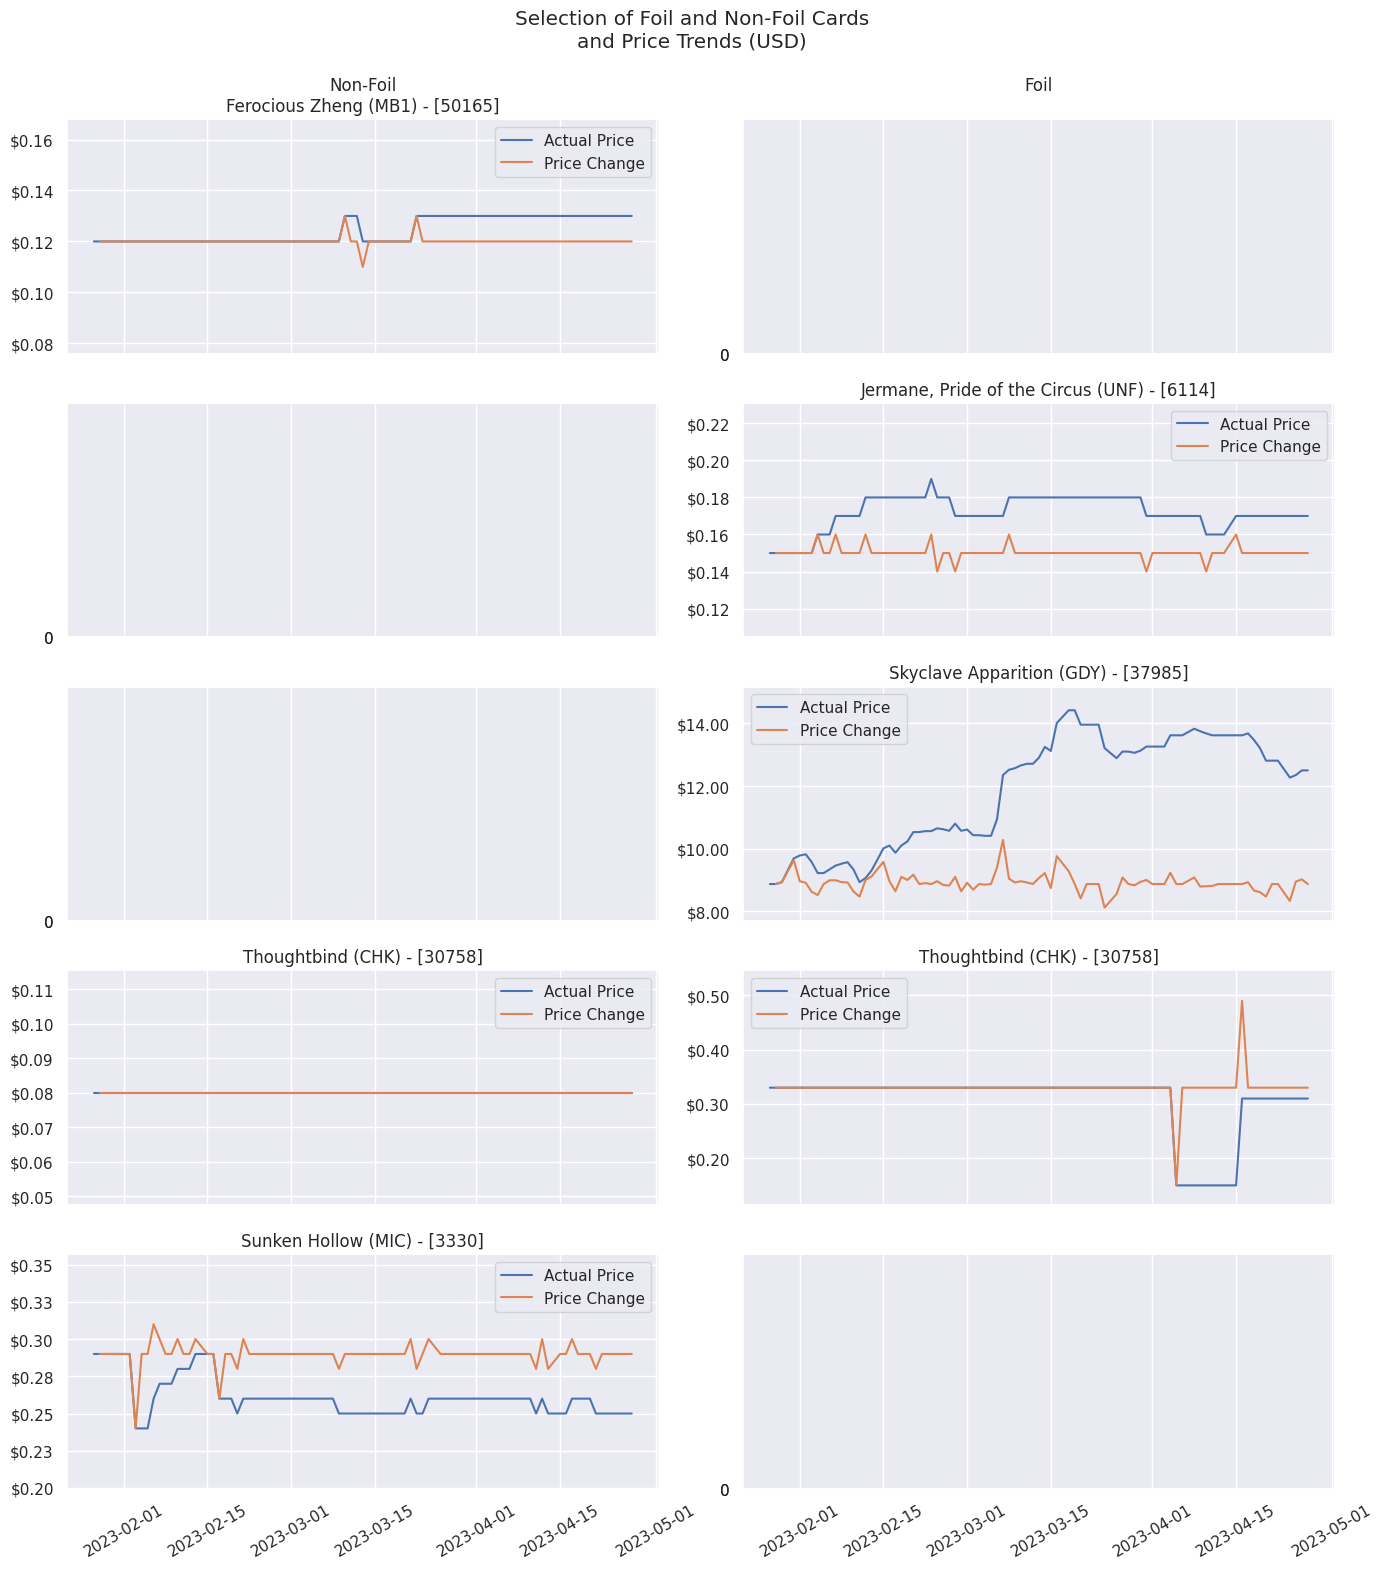

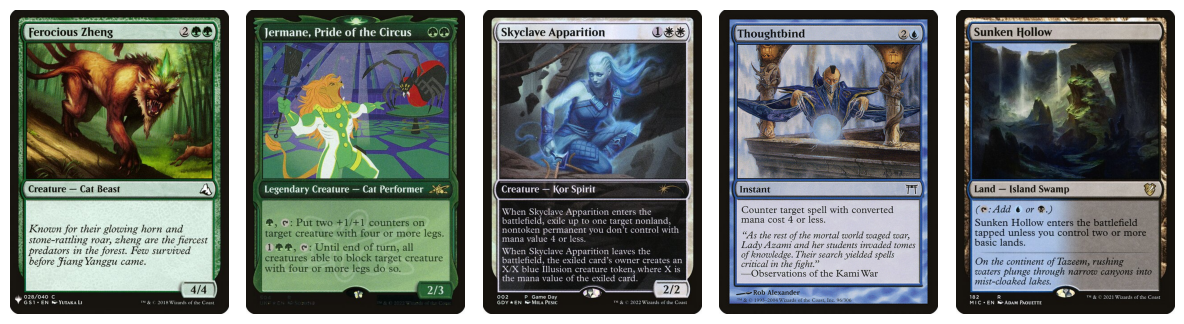

In [36]:
card_list = None
n_cards = 5

_rs = 1337

testing_cards = card_sampler(
    cards_attached_prices,
    n_cards=n_cards,
    card_list=card_list,
    random_state=_rs
)

plot_card_trends(
    testing_cards,
    card_list=card_list,
    ax_scale=3,
    n_cards=n_cards,
    random_state=_rs
)

image_uris = card_imager(
    testing_cards,
    card_list=card_list,
    img_size='png',
    width=240,
    n_cards=n_cards,
    random_state=_rs
)
'';

As we can see, some prices can fluctuate quite a bit,
as is the case with Skyclave Appariton going up in
price by $6 at one point, increasing to close to double
its starting price. Some prices are entirely stagnant,
like Thoughtbind which maintained a price of $0.08 the
entire 90 days. Each of these entries has a different
level of fluctuation across the board and all of this
is something to keep in mind as the project progresses.

For now, let's take a look at the test card data from
above.

In [38]:
testing_cards[[
    'name','released_at','mana_cost','cmc','type_line',
    'oracle_text','prices_normal','prices_foil'
]]

,name,released_at,mana_cost,cmc,type_line,oracle_text,prices_normal,prices_foil
0,Thoughtbind,2004-10-01,{2}{U},3.0,Instant,Counter target spell with mana value 4 or less.,"{'2023-01-27': 0.08, '2023-01-28': 0.08, '2023...","{'2023-01-27': 0.33, '2023-01-28': 0.33, '2023..."
1,Skyclave Apparition,2022-04-08,{1}{W}{W},3.0,Creature — Kor Spirit,When Skyclave Apparition enters the battlefiel...,None,"{'2023-01-27': 8.87, '2023-01-28': 8.87, '2023..."
2,"Jermane, Pride of the Circus",2022-10-07,{G}{G},2.0,Legendary Creature — Cat Performer,"{G}, {T}: Put two +1/+1 counters on target cre...",None,"{'2023-01-27': 0.15, '2023-01-28': 0.15, '2023..."
3,Ferocious Zheng,2019-11-07,{2}{G}{G},4.0,Creature — Cat Beast,,"{'2023-01-27': 0.12, '2023-01-28': 0.12, '2023...",None
4,Sunken Hollow,2021-09-24,,0.0,Land — Island Swamp,({T}: Add {U} or {B}.)\nSunken Hollow enters t...,"{'2023-01-27': 0.29, '2023-01-28': 0.29, '2023...",None


### Regularizing Card Names

Because our investigation is going to be focusing on
NLP to generate prices, we need to make sure that this
data contains consistent information. One strategy for
doing this that's employed by most Magic applications
is to replace the name of a card with CARDNAME whenever
it appears in its own text.

For example, Skyclave Apparition has an ability that
says:

> When Skyclave Apparition enters the battlefield...

Abilities like this are common in Magic, but in order
for us to be able to reliably catch that, we would need
to have each card's name treated the same way, since no
other cards reference Skyclave Apparition in their
abilities. For example, we would translate this card's
ability to start with:

> When CARDNAME enters the battlefield

A function to process this has already been defined, so
we can just apply it as needed.

In [39]:
testing_cards['oracle_text'] = testing_cards.apply(synthesize_names,axis=1)
testing_cards[['oracle_text']]

,oracle_text
0,Counter target spell with mana value 4 or less.
1,"When CARDNAME enters the battlefield, exile up..."
2,"{G}, {T}: Put two +1/+1 counters on target cre..."
3,
4,({T}: Add {U} or {B}.)\nCARDNAME enters the ba...


On the topic of Oracle text, let's take a quick look at
the cards from earlier that have two "faces."

In [40]:
cards_attached_prices[
    cards_attached_prices['name'].str.contains('//')
    ][['name','oracle_text']]

,name,oracle_text
57,Consecrate // Consume,NaN
139,Warrant // Warden,NaN
160,"Nissa, Vastwood Seer // Nissa, Sage Animist",NaN
348,Skyclave Cleric // Skyclave Basilica,NaN
486,Turn // Burn,NaN
...,...,...
65015,"Dorothea, Vengeful Victim // Dorothea's Retrib...",NaN
65047,Armed // Dangerous,NaN
65074,Bonecrusher Giant // Stomp,NaN
65081,Desperate Farmer // Depraved Harvester,NaN


Because these cards have more than one entity on them,
the Oracle text is actually stored differently. This
may be something that can be overcome with more time in
the future, but for now we'll go ahead and remove these
entries, as these cards would have to have an extremely
specific case made for them that takes both cards into
account separately but also treats them as the same
price, accounts for mana costs independently, etc.

It's important to note that these cards having nulls as
their oracle text is different from cards that have no
oracle text, like Ferocious Zheng, which has no
abilities but has oracle text that is made up of an
empty string.

To sanity check, let's make sure the number of nulls in
the Oracle text column is the same as the number of
nulls in the entire data frame.

In [41]:
cards_attached_prices['oracle_text'].isna().sum(),\
    cards_attached_prices[
        cards_attached_prices['name'].str.contains('//')
        ][['name','oracle_text']].shape[0]

(1047, 1047)

That all lines up, so we can go ahead and drop our
nulls in place and then do our CARDNAME processing that
we were talking about as well.

In [42]:
cards_attached_prices.dropna(subset='oracle_text',inplace=True)

cards_attached_prices['oracle_text'] = \
    cards_attached_prices.apply(
        synthesize_names,axis=1
    )

### Regularizing Pricing Data

As mentioned before, we'll be looking at 90-day medians
when it comes to our predictions and training data. We
need to convert our 90-day range into a median value.

In [43]:
def regularize(x):
    if x==None:
        return None
    else:
        return np.median(list(x.values()))

cards_attached_prices['median_normal'] = \
    cards_attached_prices['prices_normal'].apply(regularize)

cards_attached_prices['median_foil'] = \
    cards_attached_prices['prices_foil'].apply(regularize)

### Checking for Abnormalities

Because a lot of things are captured and related to the
set that a card is printed in, we'll want to prepare to
stratify our testing data across our set values. We
want to make sure that there aren't any sets that are
too small to be relevant.

In [44]:
sets = cards_attached_prices['set'].value_counts()
promo_sets_list = sets[sets <= 1].index
unique_set_cards = cards_attached_prices[
        cards_attached_prices['set'].isin(promo_sets_list)
    ][['name','set']]
display(unique_set_cards.head(), len(unique_set_cards))

,name,set
1941,Rabbit Battery,pl23
3510,Helm of Kaldra,p5dn
5823,Underworld Dreams,p2hg
6174,Flooded Strand,pnat
6925,Wasteland,mpr


34

It looks like there are 34 cards that exist in their
own sets. There are a couple of instances where the set
a card is in can be only a handful of cards, so let's
check the counts on the sets that are super small as
well.

In [46]:
promo_sets_list = sets[sets <= 10].index
unique_set_cards = cards_attached_prices[
        cards_attached_prices['set'].isin(promo_sets_list)
    ][['name','set']]
display(unique_set_cards.head(), unique_set_cards.shape[0])

,name,set
59,Elvish Aberration,pal03
77,"Kamahl, Pit Fighter",p15a
115,Scourge of Fleets,pjou
170,Plains,prwk
208,Grim Lavamancer,g06


833

As a final reduction, let's go ahead and take out the
sets that don't have enough cards to be impactful. Then
we can save the data frame off as a smaller file and
use it in the next steps.

In [47]:
reduced_cards = cards_attached_prices[
    ~cards_attached_prices['set'].isin(promo_sets_list)
    ]
display(reduced_cards.head(),reduced_cards.shape)

,id,oracle_id,name,released_at,image_uris,mana_cost,cmc,type_line,oracle_text,power,...,edhrec_rank,related_uris,promo_types,loyalty,produced_mana,variation_of,prices_normal,prices_foil,median_normal,median_foil
0,0000579f-7b35-4ed3-b44c-db2a538066fe,44623693-51d6-49ad-8cd7-140505caf02f,Fury Sliver,2006-10-06,{'small': 'https://cards.scryfall.io/small/fro...,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,3,...,6038.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN,"{'2023-01-27': 0.37, '2023-01-28': 0.37, '2023...","{'2023-01-27': 3.95, '2023-01-28': 3.95, '2023...",0.380,3.95
1,00006596-1166-4a79-8443-ca9f82e6db4e,8ae3562f-28b7-4462-96ed-be0cf7052ccc,Kor Outfitter,2009-10-02,{'small': 'https://cards.scryfall.io/small/fro...,{W}{W},2.0,Creature — Kor Soldier,"When CARDNAME enters the battlefield, you may ...",2,...,15041.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN,"{'2023-01-27': 0.11, '2023-01-28': 0.11, '2023...","{'2023-01-27': 7.5, '2023-01-28': 7.5, '2023-0...",0.240,7.78
2,0000cd57-91fe-411f-b798-646e965eec37,9f0d82ae-38bf-45d8-8cda-982b6ead1d72,Siren Lookout,2017-09-29,{'small': 'https://cards.scryfall.io/small/fro...,{2}{U},3.0,Creature — Siren Pirate,"Flying\nWhen CARDNAME enters the battlefield, ...",1,...,13249.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN,"{'2023-01-27': 0.04, '2023-01-28': 0.04, '2023...","{'2023-01-27': 0.26, '2023-01-28': 0.26, '2023...",0.060,0.23
3,00012bd8-ed68-4978-a22d-f450c8a6e048,5aa12aff-db3c-4be5-822b-3afdf536b33e,Web,1994-04-01,{'small': 'https://cards.scryfall.io/small/fro...,{G},1.0,Enchantment — Aura,Enchant creature (Target a creature as you cas...,NaN,...,20164.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN,"{'2023-01-27': 0.65, '2023-01-28': 0.65, '2023...",None,0.640,NaN
4,0001f1ef-b957-4a55-b47f-14839cdbab6f,ef027846-be81-4959-a6b5-56bd01b1e68a,Venerable Knight,2019-10-04,{'small': 'https://cards.scryfall.io/small/fro...,{W},1.0,Creature — Human Knight,"When CARDNAME dies, put a +1/+1 counter on tar...",2,...,13076.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN,"{'2023-01-27': 0.09, '2023-01-28': 0.09, '2023...","{'2023-01-27': 0.29, '2023-01-28': 0.29, '2023...",0.095,0.28


(62370, 37)

At 62,370 entries, we're ready to save this off as a
new file.

In [49]:
# # this cell is commented out to prevent accidental
# # overwriting. If running this notebook with new data
# # or to verify the entire process, this cell needs to
# # be uncommented. 

# reduced_cards.to_parquet(
#     './data/simplified_cards.parquet',
#     index=False
# )

## Moving on to the Next Step

# \<FILL DATA HERE>